# 소나(Sonar) 데이터 딥러닝 분석

**목표**: 60개의 주파수 특성 데이터를 분석하여 기뢰(Mine)와 바위(Rock)를 구분하는 딥러닝(MLP) 모델을 구축하고 성능을 검증합니다.

**작성자**: AI Assistant
**날짜**: 2026-01-09

## 1. 환경 설정 및 데이터 로드
분석에 필요한 라이브러리를 임포트하고, `sonar3.csv` 데이터를 로드합니다.
데이터의 헤더가 없으므로 `header=None`으로 설정합니다.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.linear_model import LogisticRegression

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers import Adam

# 시각화 설정
sns.set(style="whitegrid")
np.random.seed(42)

/Users/bagjongman/.pyenv/versions/3.12.8/lib/python3.12/site-packages/keras/src/export/tf2onnx_lib.py:8: FutureWarning: In the future `np.object` will be defined as the corresponding NumPy scalar.
  if not hasattr(np, "object"):


In [2]:
# 데이터 로드
df = pd.read_csv('../../data/sonar3.csv', header=None)
print(f"데이터셋 크기: {df.shape}")

# 마지막 컬럼을 'Target'으로 명명
df.rename(columns={60: 'Target'}, inplace=True)
df.head()

데이터셋 크기: (208, 61)


,0,1,2,3,4,5,6,7,8,9,...,51,52,53,54,55,56,57,58,59,Target
0,0.0200,0.0371,0.0428,0.0207,0.0954,0.0986,0.1539,0.1601,0.3109,0.2111,...,0.0027,0.0065,0.0159,0.0072,0.0167,0.0180,0.0084,0.0090,0.0032,0
1,0.0453,0.0523,0.0843,0.0689,0.1183,0.2583,0.2156,0.3481,0.3337,0.2872,...,0.0084,0.0089,0.0048,0.0094,0.0191,0.0140,0.0049,0.0052,0.0044,0
2,0.0262,0.0582,0.1099,0.1083,0.0974,0.2280,0.2431,0.3771,0.5598,0.6194,...,0.0232,0.0166,0.0095,0.0180,0.0244,0.0316,0.0164,0.0095,0.0078,0
3,0.0100,0.0171,0.0623,0.0205,0.0205,0.0368,0.1098,0.1276,0.0598,0.1264,...,0.0121,0.0036,0.0150,0.0085,0.0073,0.0050,0.0044,0.0040,0.0117,0
4,0.0762,0.0666,0.0481,0.0394,0.0590,0.0649,0.1209,0.2467,0.3564,0.4459,...,0.0031,0.0054,0.0105,0.0110,0.0015,0.0072,0.0048,0.0107,0.0094,0


## 2. 데이터 탐색 및 품질 검증 (EDA)
데이터의 결측치 유무와 타겟 클래스(기뢰 vs 바위)의 비율을 확인합니다.

In [3]:
# 데이터 정보 및 결측치 확인
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 208 entries, 0 to 207
Data columns (total 61 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   0       208 non-null    float64
 1   1       208 non-null    float64
 2   2       208 non-null    float64
 3   3       208 non-null    float64
 4   4       208 non-null    float64
 5   5       208 non-null    float64
 6   6       208 non-null    float64
 7   7       208 non-null    float64
 8   8       208 non-null    float64
 9   9       208 non-null    float64
 10  10      208 non-null    float64
 11  11      208 non-null    float64
 12  12      208 non-null    float64
 13  13      208 non-null    float64
 14  14      208 non-null    float64
 15  15      208 non-null    float64
 16  16      208 non-null    float64
 17  17      208 non-null    float64
 18  18      208 non-null    float64
 19  19      208 non-null    float64
 20  20      208 non-null    float64
 21  21      208 non-null    float64
 22  22

Target
1    111
0     97
Name: count, dtype: int64


/Users/bagjongman/.pyenv/versions/3.12.8/lib/python3.12/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 53440 (\N{HANGUL SYLLABLE TA}) missing from font(s) Arial.
  fig.canvas.print_figure(bytes_io, **kw)
/Users/bagjongman/.pyenv/versions/3.12.8/lib/python3.12/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 44191 (\N{HANGUL SYLLABLE GES}) missing from font(s) Arial.
  fig.canvas.print_figure(bytes_io, **kw)
/Users/bagjongman/.pyenv/versions/3.12.8/lib/python3.12/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 53364 (\N{HANGUL SYLLABLE KEUL}) missing from font(s) Arial.
  fig.canvas.print_figure(bytes_io, **kw)
/Users/bagjongman/.pyenv/versions/3.12.8/lib/python3.12/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 47000 (\N{HANGUL SYLLABLE RAE}) missing from font(s) Arial.
  fig.canvas.print_figure(bytes_io, **kw)
/Users/bagjongman/.pyenv/versions/3.12.8/lib/python3.12/site-packages/IPython/core/pylabtools.py:170: UserWa

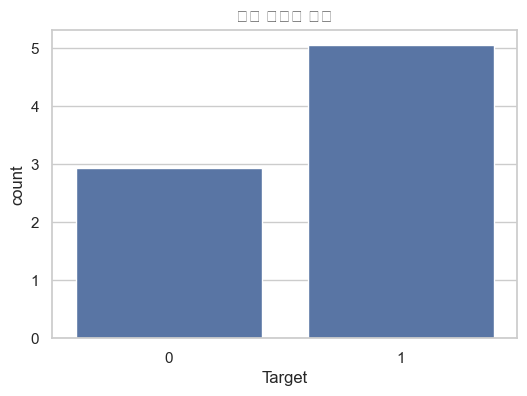

In [4]:
# 클래스 균형 확인
print(df['Target'].value_counts())

plt.figure(figsize=(6, 4))
sns.countplot(x='Target', data=df)
plt.title("타겟 클래스 분포")
plt.show()

**해석**:
- 총 208개의 샘플이 있으며 결측치는 없는 것으로 확인됩니다.
- 타겟 클래스는 비교적 균형 잡혀 있으나, 정확한 모델 학습을 위해 `Stratified Split`을 사용하는 것이 좋습니다.

## 3. 데이터 전처리 (Preprocessing)
- **Feature/Target 분리**: 60개의 특성과 타겟을 분리합니다.
- **스케일링 (Scaling)**: 딥러닝 모델의 학습 수렴을 돕기 위해 `StandardScaler`를 적용합니다.
- **데이터 분할**: 학습용(Train)과 테스트용(Test) 데이터를 8:2 비율로 분할합니다.

In [5]:
X = df.iloc[:, 0:60]
y = df['Target']

# 타겟 레이블 확인 및 변환 (만약 문자열이라면)
if y.dtype == 'object':
    le = LabelEncoder()
    y = le.fit_transform(y)
    print("변환된 레이블:", np.unique(y))

# 학습/테스트 데이터 분할
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

# 스케일링
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

print("Train Set:", X_train_scaled.shape)
print("Test Set:", X_test_scaled.shape)

Train Set: (166, 60)
Test Set: (42, 60)


## 4. 모델링 1: 베이스라인 (Logistic Regression)
복잡한 딥러닝 모델을 만들기 전에, 선형 모델인 로지스틱 회귀로 기준 성능을 확인합니다.

In [6]:
lr_model = LogisticRegression()
lr_model.fit(X_train_scaled, y_train)

y_pred_lr = lr_model.predict(X_test_scaled)
acc_lr = accuracy_score(y_test, y_pred_lr)
print(f"Logistic Regression 정확도: {acc_lr:.4f}")

Logistic Regression 정확도: 0.8333


## 5. 모델링 2: 딥러닝 (MLP)
Keras를 사용하여 은닉층이 2개인 신경망 모델을 설계합니다.

**아키텍처**:
- 입력층: 60개 노드
- 은닉층 1: 24개 노드, ReLU
- 은닉층 2: 10개 노드, ReLU
- 출력층: 1개 노드, Sigmoid (이진 분류)

In [7]:
def create_mlp_model():
    model = Sequential()
    model.add(Dense(24, input_dim=60, activation='relu'))
    model.add(Dense(10, activation='relu'))
    model.add(Dense(1, activation='sigmoid'))
    
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model

model = create_mlp_model()
model.summary()

/Users/bagjongman/.pyenv/versions/3.12.8/lib/python3.12/site-packages/keras/src/layers/core/dense.py:106: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
2026-01-09 11:58:00.094410: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M1 Max
2026-01-09 11:58:00.095645: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 64.00 GB
2026-01-09 11:58:00.095831: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 25.92 GB
2026-01-09 11:58:00.095965: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2026-01-09 11:58:00.096004: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_fac

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 24)             │         1,464 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 10)             │           250 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 1)              │            11 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,725 (6.74 KB)

 Trainable params: 1,725 (6.74 KB)

 Non-trainable params: 0 (0.00 B)

2026-01-09 11:58:00.594582: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:117] Plugin optimizer for device_type GPU is enabled.


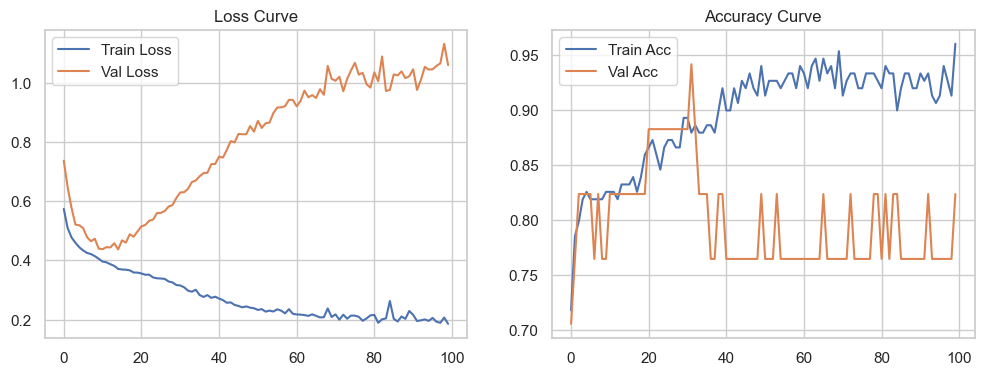

In [8]:
# 모델 학습
history = model.fit(X_train_scaled, y_train, epochs=100, batch_size=5, verbose=0, validation_split=0.1)

# 학습 곡선 시각화
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title('Loss Curve')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Train Acc')
plt.plot(history.history['val_accuracy'], label='Val Acc')
plt.title('Accuracy Curve')
plt.legend()

plt.show()

**해석**:
- Loss 곡선이 감소하고 Accuracy가 증가하는지 확인합니다.
- Train Loss는 계속 줄어드는데 Val Loss가 다시 증가한다면 과적합(Overfitting)을 의심할 수 있습니다.

## 6. 교차 검증 (Cross Validation)
데이터셋이 작으므로, 특정 테스트 셋에 편향되지 않은 성능을 확인하기 위해 `Stratified K-Fold` 교차 검증을 수행합니다.

In [9]:
kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
cv_scores = []

print("딥러닝 모델 K-Fold 교차 검증 시작...")
for train_idx, val_idx in kfold.split(X, y):
    # Fold별 데이터 분할
    X_k_train, X_k_val = X.iloc[train_idx], X.iloc[val_idx]
    y_k_train, y_k_val = y[train_idx], y[val_idx]
    
    # 스케일링 (각 Fold마다 새로 적용해야 정보 누수 방지)
    k_scaler = StandardScaler()
    X_k_train_s = k_scaler.fit_transform(X_k_train)
    X_k_val_s = k_scaler.transform(X_k_val)
    
    # 모델 초기화 및 학습
    k_model = create_mlp_model()
    k_model.fit(X_k_train_s, y_k_train, epochs=100, batch_size=5, verbose=0)
    
    # 평가
    score = k_model.evaluate(X_k_val_s, y_k_val, verbose=0)[1]
    print(f"Fold 정확도: {score:.4f}")
    cv_scores.append(score)

print("\n평균 검증 정확도: {:.4f}".format(np.mean(cv_scores)))

딥러닝 모델 K-Fold 교차 검증 시작...


/Users/bagjongman/.pyenv/versions/3.12.8/lib/python3.12/site-packages/keras/src/layers/core/dense.py:106: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Fold 정확도: 0.7381


/Users/bagjongman/.pyenv/versions/3.12.8/lib/python3.12/site-packages/keras/src/layers/core/dense.py:106: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Fold 정확도: 0.8095


/Users/bagjongman/.pyenv/versions/3.12.8/lib/python3.12/site-packages/keras/src/layers/core/dense.py:106: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Fold 정확도: 0.7143


/Users/bagjongman/.pyenv/versions/3.12.8/lib/python3.12/site-packages/keras/src/layers/core/dense.py:106: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Fold 정확도: 0.7805


/Users/bagjongman/.pyenv/versions/3.12.8/lib/python3.12/site-packages/keras/src/layers/core/dense.py:106: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Fold 정확도: 0.7317

평균 검증 정확도: 0.7548


## 7. 최종 평가 및 결론
처음 분리해둔 Hold-out Test Set으로 최종 성능을 평가합니다.

In [10]:
# 딥러닝 모델 최종 평가
test_loss, test_acc = model.evaluate(X_test_scaled, y_test, verbose=0)
print(f"딥러닝 모델 최종 Test 정확도: {test_acc:.4f}")

# 베이스라인과 비교
print(f"베이스라인(Logistic) Test 정확도: {acc_lr:.4f}")

딥러닝 모델 최종 Test 정확도: 0.8571
베이스라인(Logistic) Test 정확도: 0.8333
